<a href="https://colab.research.google.com/github/Jillian-T/DPGM/blob/main/DPGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from dataclasses import dataclass
from torch.distributions import Gamma, Multinomial

c:\Users\j1487\miniconda3\envs\EPM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
@dataclass
class ExperimentConfig:
    N: int
    K: int
    T: int
    train_ratio: float
    burnin: int
    collection: int
    binary: bool

config = ExperimentConfig(60, 30, 6, 1., 1500, 1500, True)

In [5]:
synthetic_data = []

_data = torch.block_diag(
    torch.triu(torch.ones(10, 10), 1),
    torch.triu(torch.ones(20, 20), 1),
    torch.triu(torch.ones(30, 30), 1)
)
synthetic_data.append(_data)

_data = torch.block_diag(
    torch.triu(torch.ones(15, 15), 1),
    torch.triu(torch.ones(10, 10), 1),
    torch.triu(torch.ones(10, 10), 1),
    torch.triu(torch.ones(25, 25), 1)
)
synthetic_data.append(_data)

_data = torch.block_diag(
    torch.triu(torch.ones(20, 20), 1),
    torch.triu(torch.ones(10, 10), 1),
    torch.triu(torch.ones(10, 10), 1),
    torch.triu(torch.ones(20, 20), 1)
)
synthetic_data.append(_data)

_data = torch.block_diag(
    torch.triu(torch.ones(30, 30), 1),
    torch.triu(torch.ones(15, 15), 1),
    torch.triu(torch.ones(15, 15), 1)
)
synthetic_data.append(_data)

_data = torch.block_diag(
    torch.triu(torch.ones(30, 30), 1),
    torch.triu(torch.ones(20, 20), 1),
    torch.triu(torch.ones(10, 10), 1)
)
synthetic_data.append(_data)

_data = torch.block_diag(
    torch.triu(torch.ones(35, 35), 1),
    torch.triu(torch.ones(15, 15), 1),
    torch.triu(torch.ones(10, 10), 1)
)
synthetic_data.append(_data)

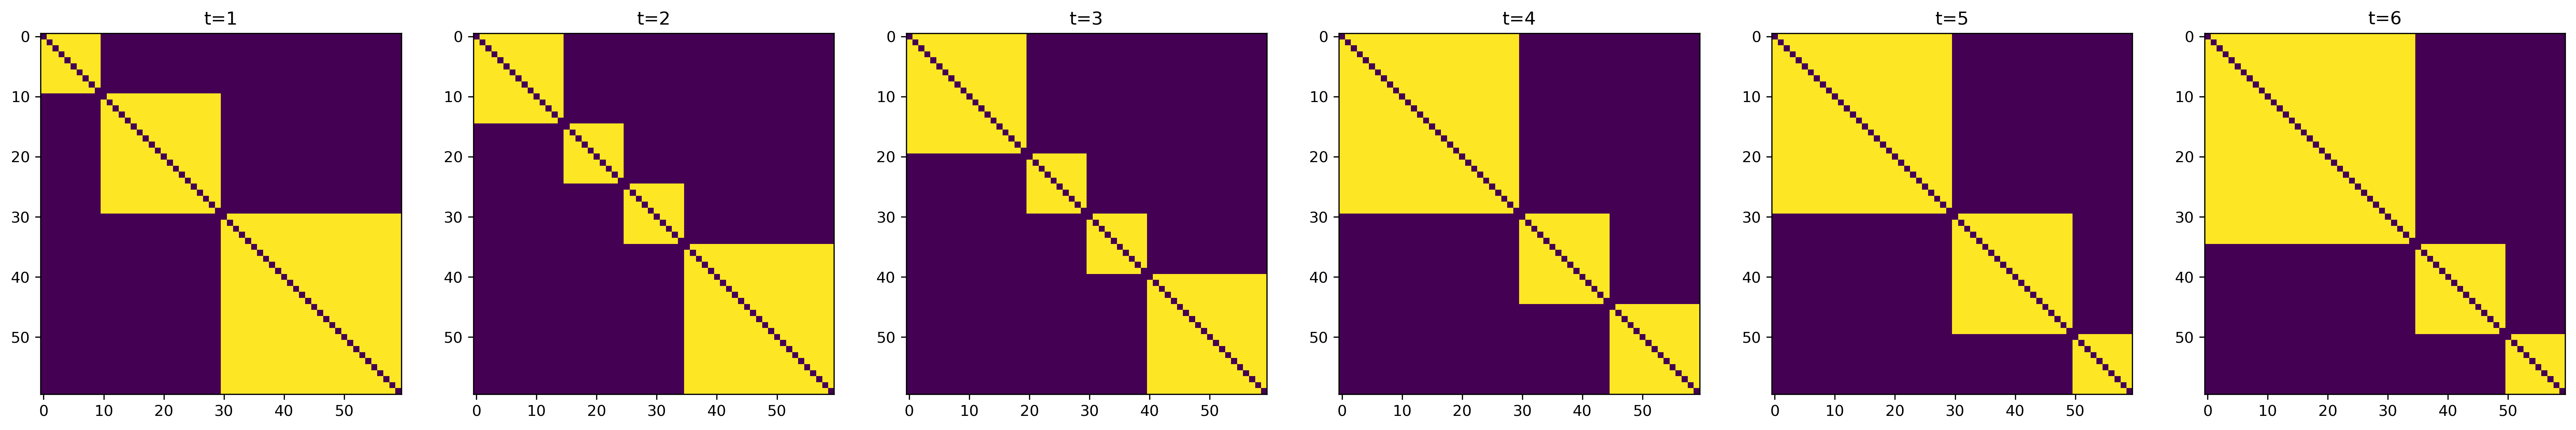

In [6]:
fig, ax = plt.subplots(1, config.T, figsize=(30, 5), dpi=300)
for t in range(config.T):
    ax[t].imshow(synthetic_data[t] + synthetic_data[t].T)
    ax[t].set_title(f't={t+1}')

In [7]:
B = []
m_idx = []
n_idx = []
for t in range(config.T):
    m_t, n_t = torch.nonzero(synthetic_data[t], as_tuple=True)
    b = synthetic_data[t][m_t, n_t]
    B.append(b)
    m_idx.append(m_t)
    n_idx.append(n_t)

In [8]:
eps = 1e-32

def Po_plus(rate):
    r1 = rate[rate>=1]
    r2 = rate[rate<1]
    m = torch.zeros_like(rate)
    m1 = torch.zeros_like(r1)
    m2 = torch.zeros_like(r2)

    while True:
        dex = (m1 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r1[dex]
            temp = torch.poisson(r_dex)
            idex = temp > 0
            m1[dex] = torch.where(idex, temp, m1[dex])
    m[rate>=1] = m1

    while True:
        dex = (m2 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r2[dex]
            temp = 1 + torch.poisson(r_dex)
            idex = torch.rand_like(temp) < (1 / temp)
            m2[dex] = torch.where(idex, temp, m2[dex])
    m[rate<1] = m2

    return m

def CRT(n, a):
    max_x = torch.max(n)
    rates = torch.arange(0, max_x).expand(*n.size(), -1)
    rates = a.unsqueeze(-1) / (a.unsqueeze(-1) + rates)
    bers = torch.bernoulli(rates)
    mask = (torch.arange(0, max_x).expand(*n.size(), -1) < n.unsqueeze(-1)).to(torch.int)
    bers = bers * mask
    return torch.sum(bers, dim=-1)

class HGPDR:
    def __init__(self, config: ExperimentConfig):
        self.N = config.N
        self.K = config.K
        self.T = config.T
        self.binary = config.binary

        self.gamma_0 = 1.
        self.c_0 = 1.
        self.xi = 1.
        self.beta = 1.

        self.e_0 = 1.
        self.h_0 = 1.
        self.f_0 = 1.
        self.g_0 = 1.
        self.v_0 = 1.
        self.a_0 = 1.
        self.b_0 = 1.
        self.tau = 1.

        self.r = torch.ones(self.K) / self.K
        self.phi_o = Gamma(1., 1.).sample([self.N, self.K])
        self.phi = Gamma(1., 1.).sample([self.T, self.N, self.K])

        lam_kk = self.r.view(-1, 1) @ self.r.view(1, -1)
        lam_kk = torch.triu(lam_kk, 1) + torch.triu(lam_kk, 1).T
        lam_kk[torch.eye(self.K, self.K, dtype=torch.bool)] = self.r * self.xi
        self.lam_kk = lam_kk

    def do_inference(self, B, m_idx, n_idx):
        diag_mask = torch.eye(self.K, self.K, dtype=torch.bool)
        triu_mask = torch.triu(torch.ones(self.K, self.K, dtype=torch.bool), diagonal=1)

        # Sample latents then x_dot_kk_dot_t and x_mnk_ddot
        x_dot_kk_dot_t = torch.zeros(self.K, self.K)
        x_mnk_ddot = torch.zeros(self.T, self.N, self.K)
        for t in range(self.T):
            rate = torch.sum((self.phi[t][m_idx[t]] @ self.lam_kk) * self.phi[t][n_idx[t]],dim=-1)   # size=(num)
            latents_t = Po_plus(rate)#B[t] * Po_plus(rate)
            diag_kk_temp = torch.zeros(self.K, self.K)
            for m, n, l in zip(m_idx[t], n_idx[t], latents_t):
                pmf = (self.phi[t, m].view(-1, 1) @ self.phi[t, n].view(1, -1)) * self.lam_kk     # size=(K, K)
                x_mkkn_t = Multinomial(l.to(torch.int).item(), pmf.flatten()).sample()
                x_mkkn_t = torch.reshape(x_mkkn_t, [self.K, self.K])
                x_mnk_ddot[t,m] = x_mnk_ddot[t,m] + x_mkkn_t.sum(dim=-1)
                x_mnk_ddot[t,n] = x_mnk_ddot[t,n] + x_mkkn_t.sum(dim=0)
                diag_kk_temp = diag_kk_temp + x_mkkn_t + x_mkkn_t.T
            diag_kk_temp[diag_mask] /= 2
            x_dot_kk_dot_t += diag_kk_temp


        # Sample l_kk then update r and temp
        ## Calculate the quantities theta_kk and one_minus_p_tilde_kk
        theta_kk = torch.einsum('ijk,ikl->jl', self.phi.permute(0,-1,1), self.phi.sum(1, keepdim=True) - self.phi)
        theta_kk[diag_mask] = theta_kk[diag_mask] / 2
        one_minus_p_tilde_kk = torch.clamp_min(self.beta / (self.beta + theta_kk), eps)

        ## update r and temp
        r_xi = torch.unsqueeze(self.r, 0).repeat(self.K, 1).clone()
        r_xi[diag_mask] = self.r
        l_kk = CRT(x_dot_kk_dot_t, torch.diag(self.r) @ r_xi + eps)
        temp = torch.sum(r_xi * torch.log(one_minus_p_tilde_kk), dim=-1)
        self.r = Gamma(self.gamma_0/self.K + l_kk.sum(dim=-1), self.c_0 - temp).sample()


        # Sample xi
        ell = torch.sum(CRT(x_dot_kk_dot_t[diag_mask], self.xi * self.r + eps))
        self.xi = Gamma(0.01 + ell, 0.01 - torch.sum(self.r * torch.log(one_minus_p_tilde_kk))).sample().item()


        # Sample lam_kk
        r_kk = self.r.view(-1, 1) @ self.r.view(1, -1)
        r_kk[diag_mask] = self.xi * self.r
        lam_kk = torch.zeros(self.K, self.K) + eps
        lam_kk[diag_mask] = Gamma(x_dot_kk_dot_t[diag_mask] + r_kk[diag_mask], self.beta + theta_kk[diag_mask]).sample()
        lam_kk[triu_mask] = Gamma(x_dot_kk_dot_t[triu_mask] + r_kk[triu_mask], self.beta + theta_kk[triu_mask]).sample()
        self.lam_kk = lam_kk + torch.triu(lam_kk, 1).T


        # Sample beta
        self.beta = Gamma(1 + r_kk[diag_mask | triu_mask].sum(), 1 + self.lam_kk[diag_mask | triu_mask].sum()).sample().item()


        # Sample gamma_0
        l_k_tilde = CRT(l_kk.sum(dim=-1), torch.full((self.K,), self.gamma_0/self.K))
        temp = torch.clamp_min(self.c_0 / (self.c_0 - temp), eps)
        self.gamma_0 = Gamma(self.e_0 + l_k_tilde.sum(), self.h_0 - 1/self.K * torch.log(temp).sum()).sample().item()


        # Sample c_0
        self.c_0 = Gamma(0.01 + self.gamma_0, 0.01 + self.r.sum()).sample().item()


        # Sample phi
        omega_nk = (self.phi.sum(dim=1, keepdim=True) - self.phi) @ self.lam_kk     # size=(T,N,K)
        re_omega_nk = torch.flip(omega_nk.clone(), dims=[0])

        ## Backward: sample ro_nk from T to 1
        ro_nk = torch.zeros_like(re_omega_nk)
        ro_nk[0] = re_omega_nk[0] / (re_omega_nk[0] + self.tau)
        for t in range(1, self.T):
            temp_ro = re_omega_nk[t] - torch.log(torch.clamp_min(1 - ro_nk[t-1], eps))
            ro_nk[t] = temp_ro / (self.tau + temp_ro)
        ro_nk = torch.flip(ro_nk, dims=[0])

        ## Backward: sample y_nk from T to 1
        y_nk = torch.zeros_like(omega_nk)           # size=(T,N,K)
        y_nk[-1] = CRT(x_mnk_ddot[-1], self.phi[-2])
        # for t in range(self.T - 2, 0, -1):
        #     y_nk[t] = CRT(x_mnk_ddot[t] + y_nk[t+1], self.phi[t-1])
        y_nk[1:self.T-1] = CRT(x_mnk_ddot[1:self.T-1] + y_nk[2:self.T], self.phi[:self.T-2])
        y_nk[0] = CRT(x_mnk_ddot[0] + y_nk[1], self.phi_o)
        y_nk_o = CRT(x_mnk_ddot[0], torch.full_like(x_mnk_ddot[0], self.g_0))

        ## Forward: from 1 to T sample phi
        self.phi_o = Gamma(self.g_0 + y_nk[0], self.f_0 - torch.log(torch.clamp_min(1 - ro_nk[0], eps))).sample()
        phi_lam = self.phi[0] @ self.lam_kk     # size=(N,K)
        temp = phi_lam.sum(dim=0)               # size=(K)
        for i in torch.randperm(self.N):
            temp = temp - phi_lam[i]            # (K) - (K)
            self.phi[0, i] = Gamma(self.phi_o[i] + y_nk[1, i] + x_mnk_ddot[0, i], self.tau + temp - torch.log(torch.clamp_min(1 - ro_nk[1, i], eps))).sample()
            temp = temp + self.phi[0, i] @ self.lam_kk

        for t in range(1, self.T-1):
            phi_lam = self.phi[t] @ self.lam_kk     # size=(N,K)
            temp = phi_lam.sum(dim=0)               # size=(K)
            for i in torch.randperm(self.N):
                temp = temp - phi_lam[i]            # (K) - (K)
                self.phi[t, i] = Gamma(self.phi[t-1, i] + y_nk[t+1, i] + x_mnk_ddot[t, i], self.tau + temp - torch.log(torch.clamp_min(1 - ro_nk[t+1, i], eps))).sample()
                temp = temp + self.phi[t, i] @ self.lam_kk

        phi_lam = self.phi[-1] @ self.lam_kk    # size=(N,K)
        temp = phi_lam.sum(dim=0)               # size=(K)
        for i in torch.randperm(self.N):
            temp = temp - phi_lam[i]            # (K) - (K)
            self.phi[-1, i] = Gamma(self.phi[-1, i] + x_mnk_ddot[-1, i], self.tau + temp).sample()
            temp = temp + self.phi[-1, i] @ self.lam_kk


        # Sample g_0
        self.g_0 = Gamma(1. + torch.sum(y_nk_o), 1.).sample().item()


        # Sample f_0
        self.f_0 = Gamma(self.g_0 * self.N * self.K + self.a_0, self.b_0 + torch.sum(self.phi_o)).sample().item()

        return len(torch.nonzero(x_mnk_ddot.sum(dim=0).sum(dim=0)))

K:18, gamma_0:7.95791: 100%|██████████| 3000/3000 [2:20:59<00:00,  2.82s/it]   


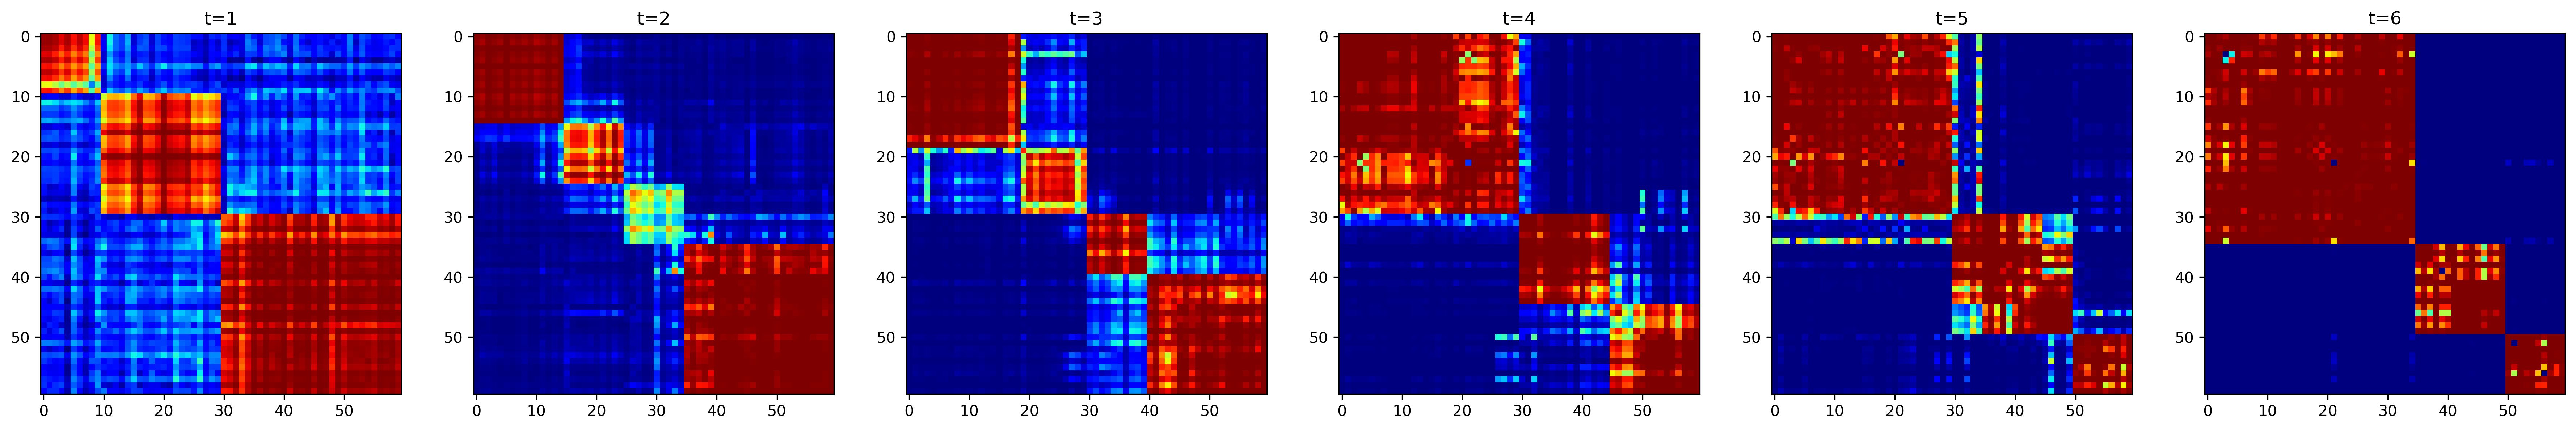

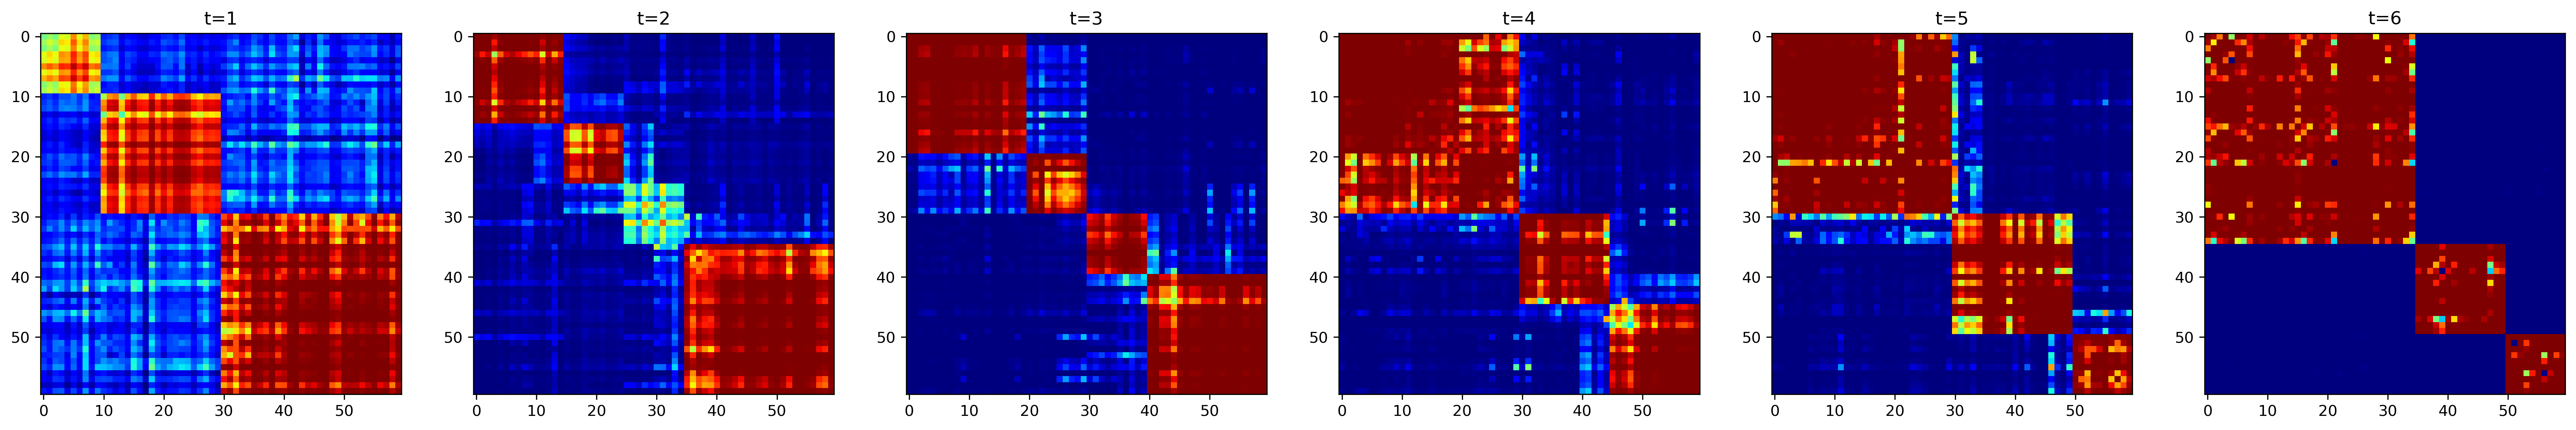

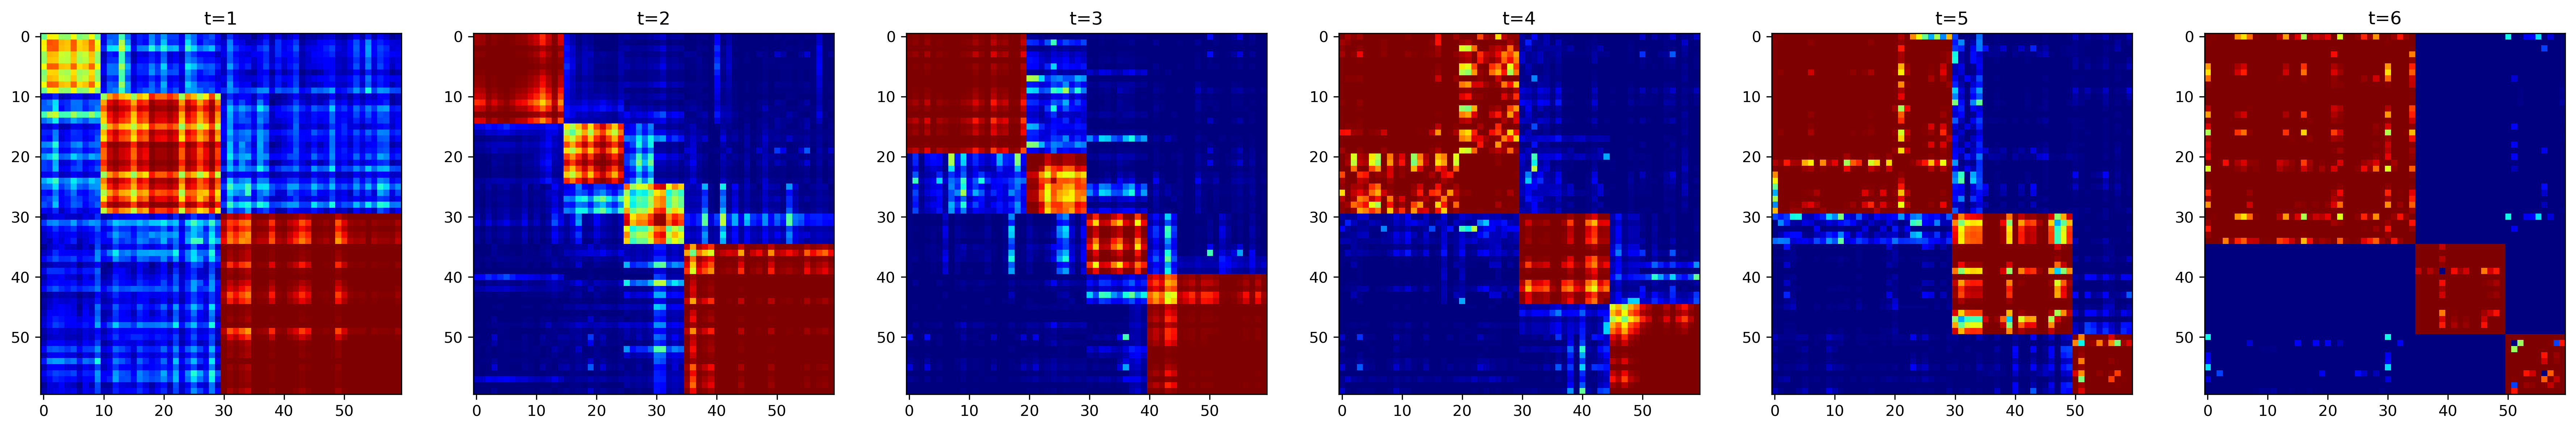

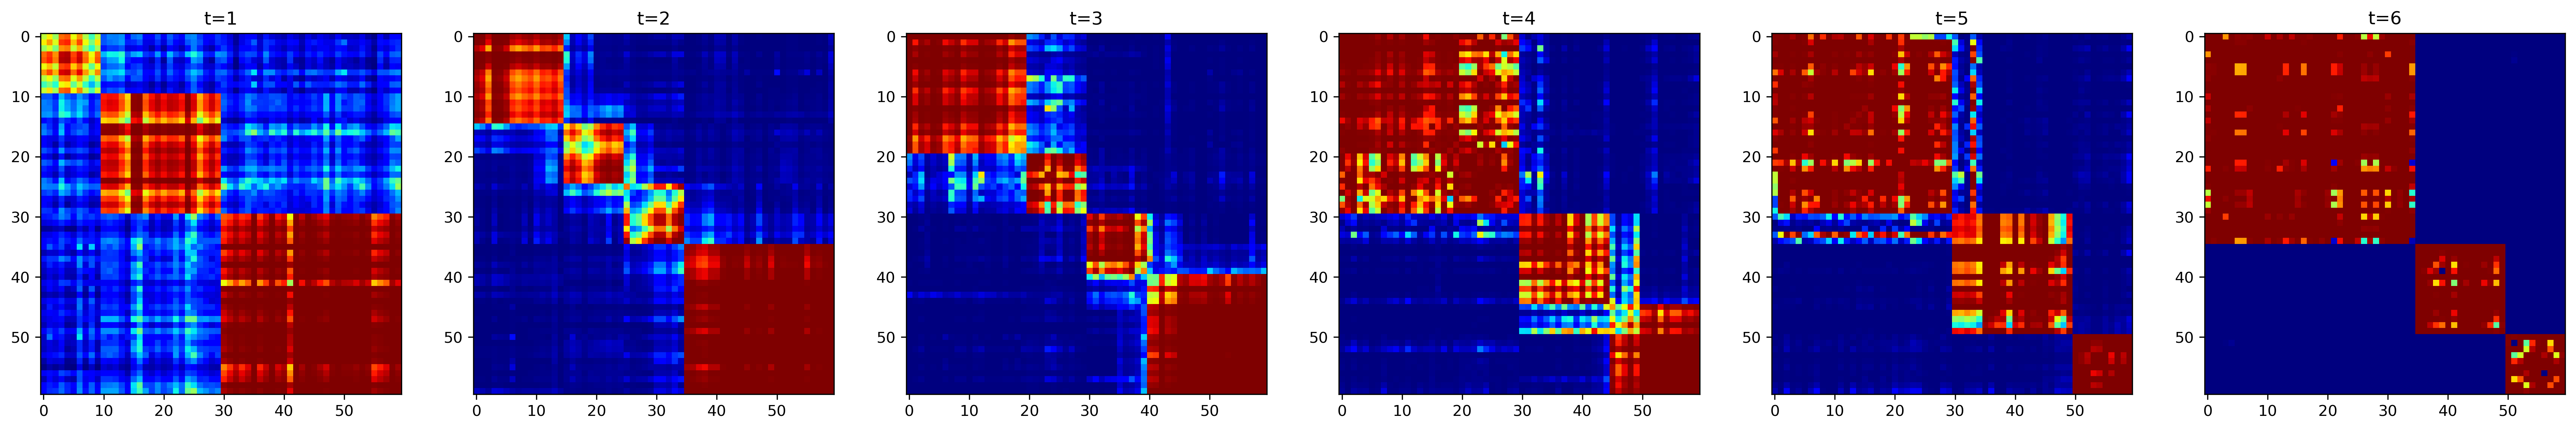

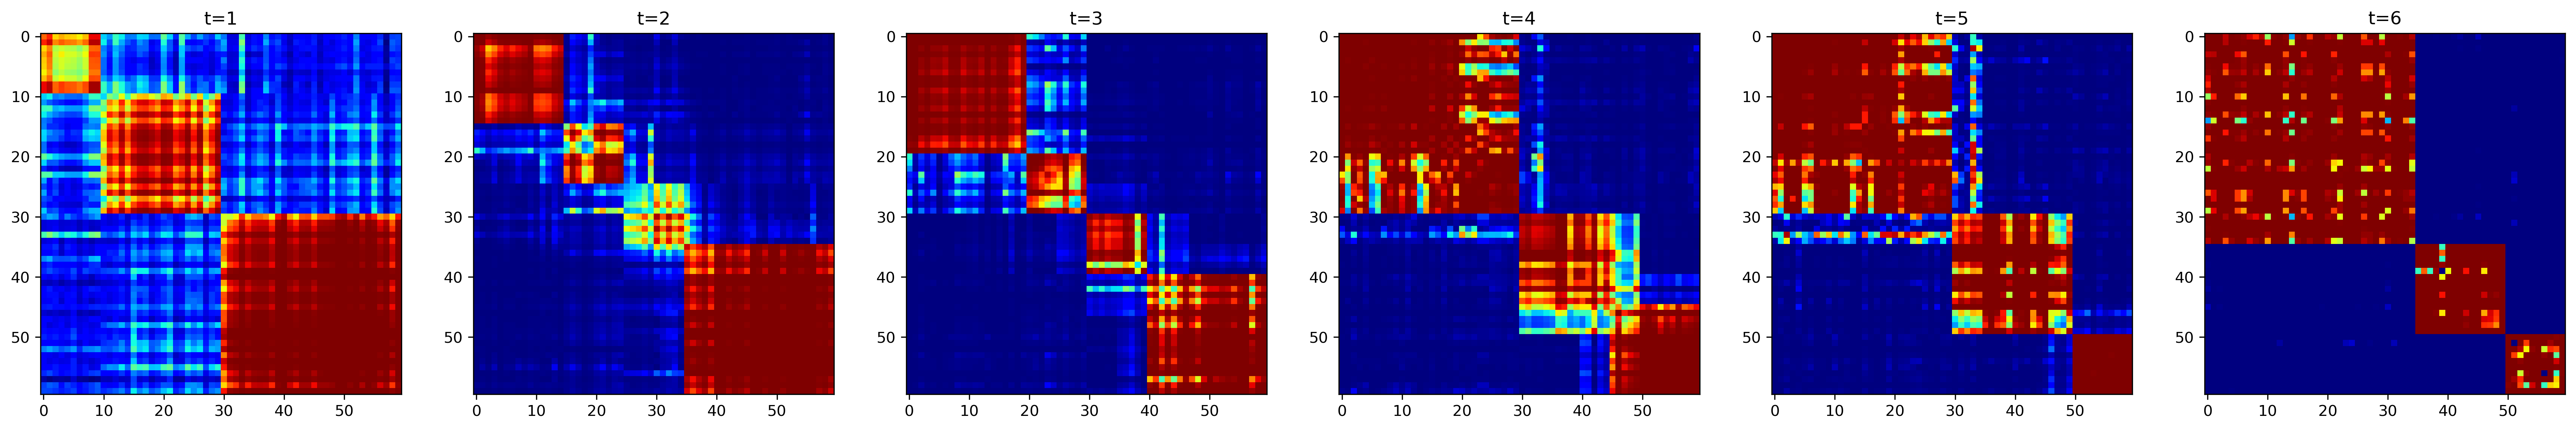

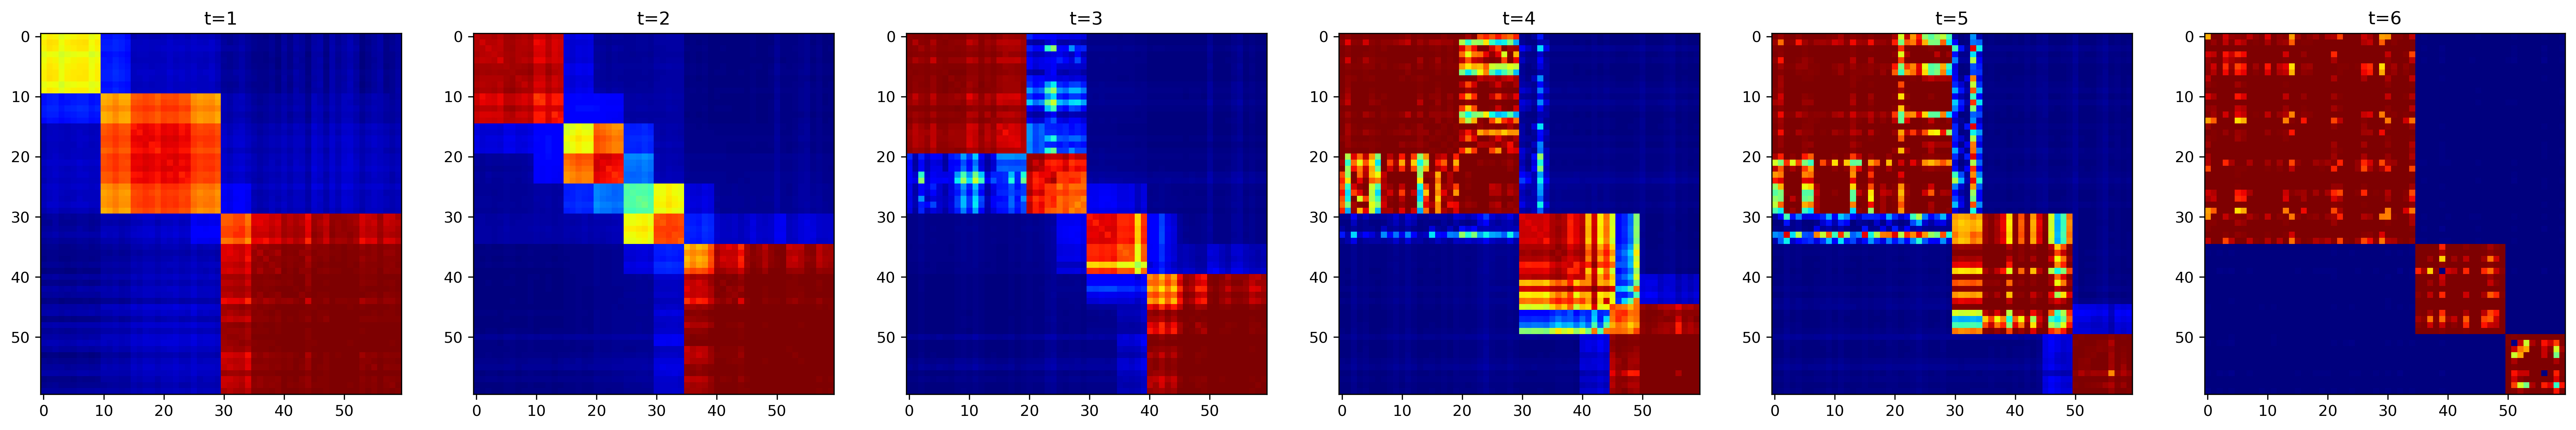

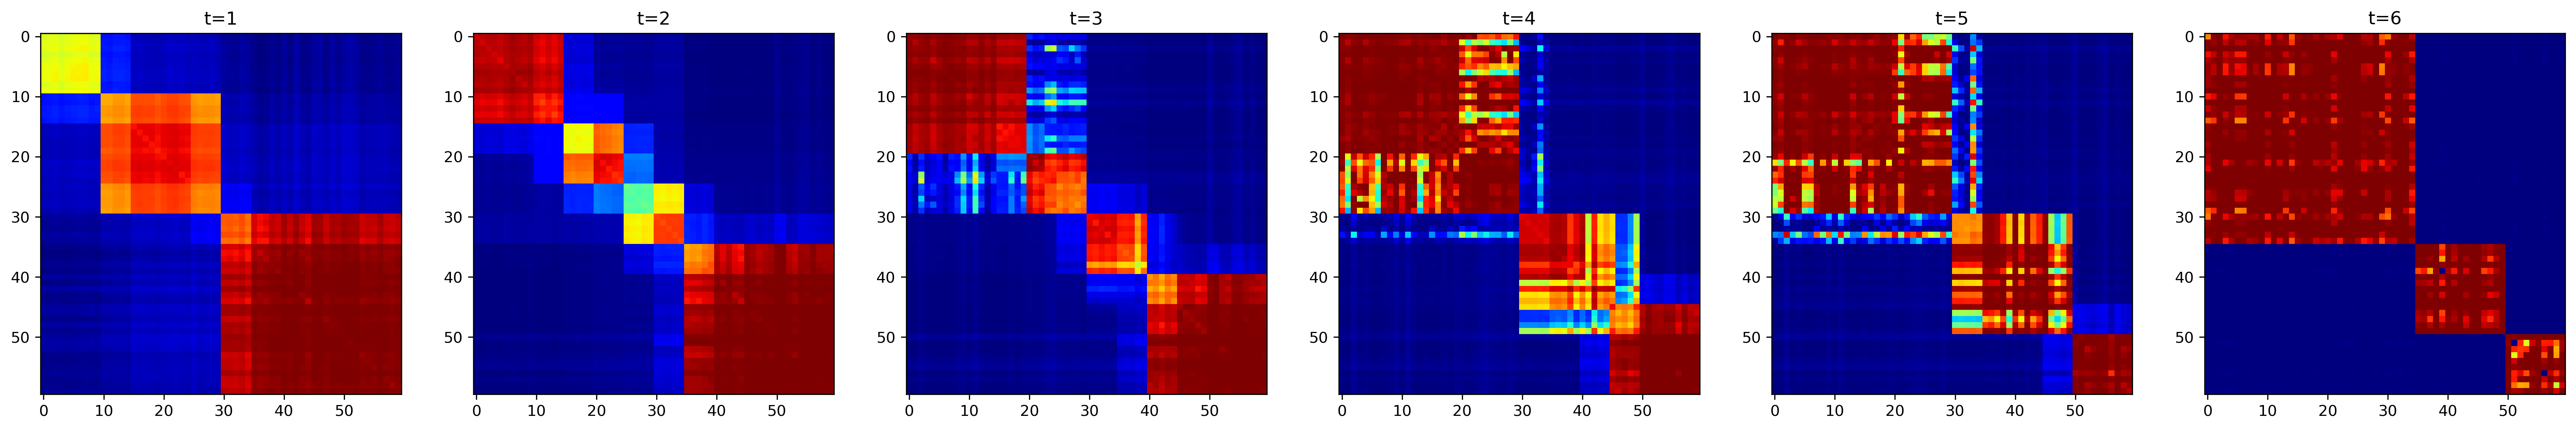

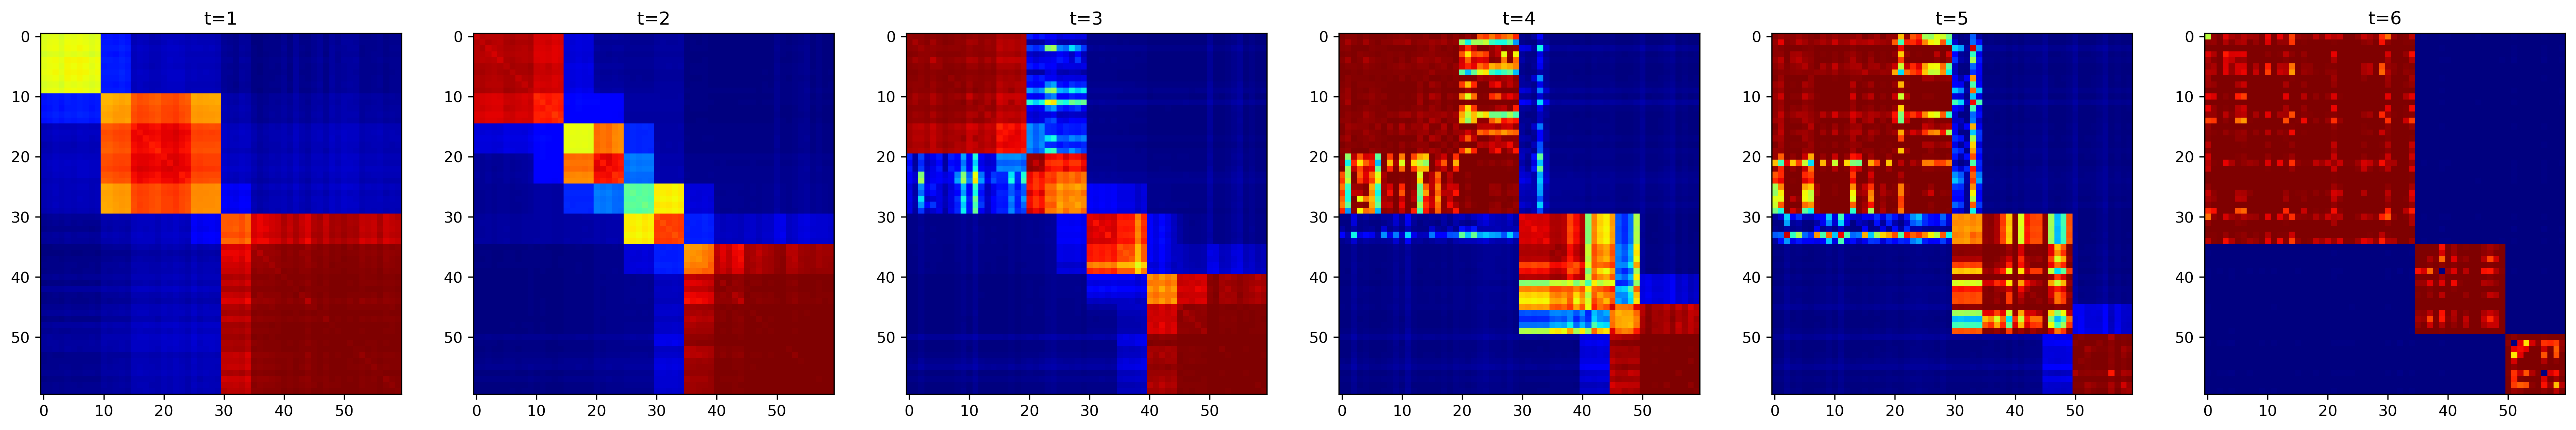

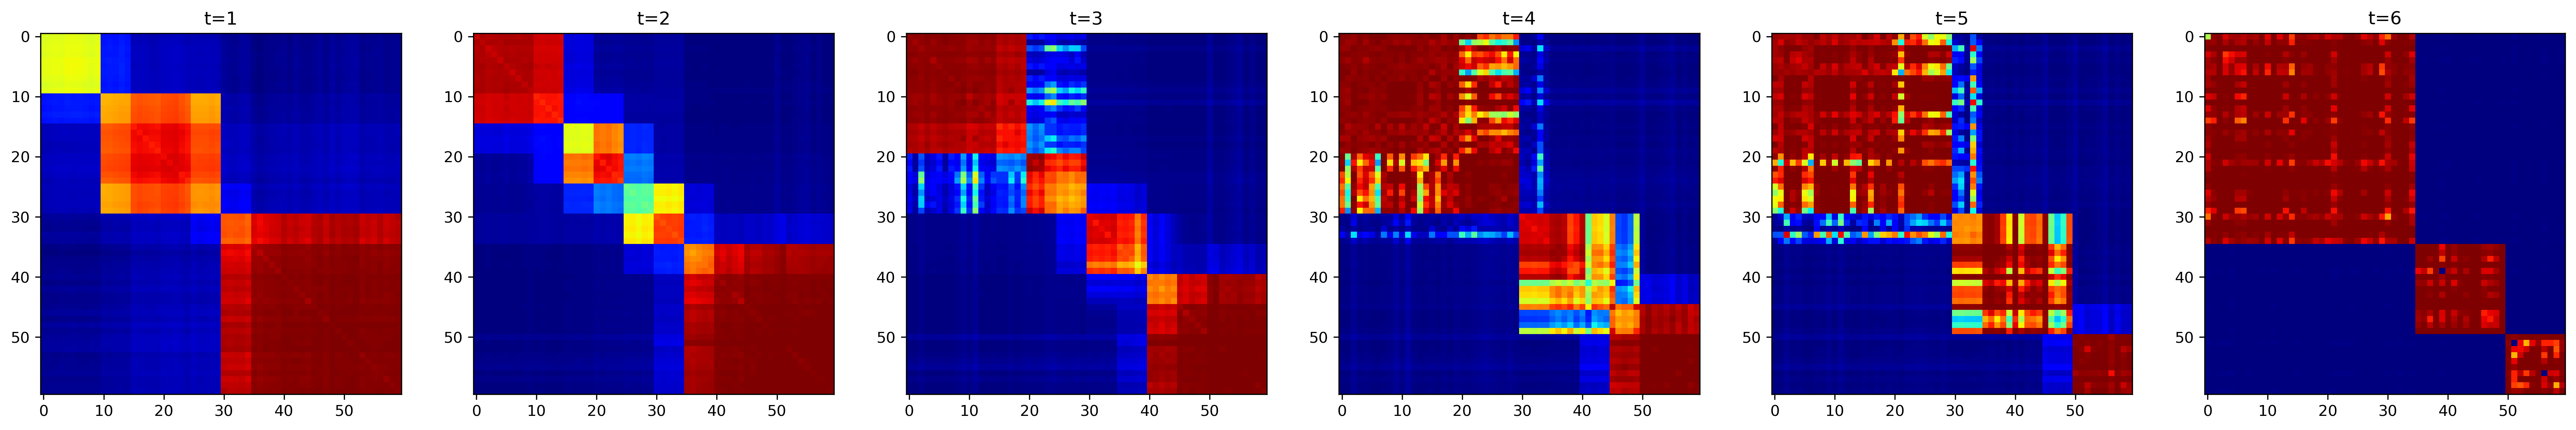

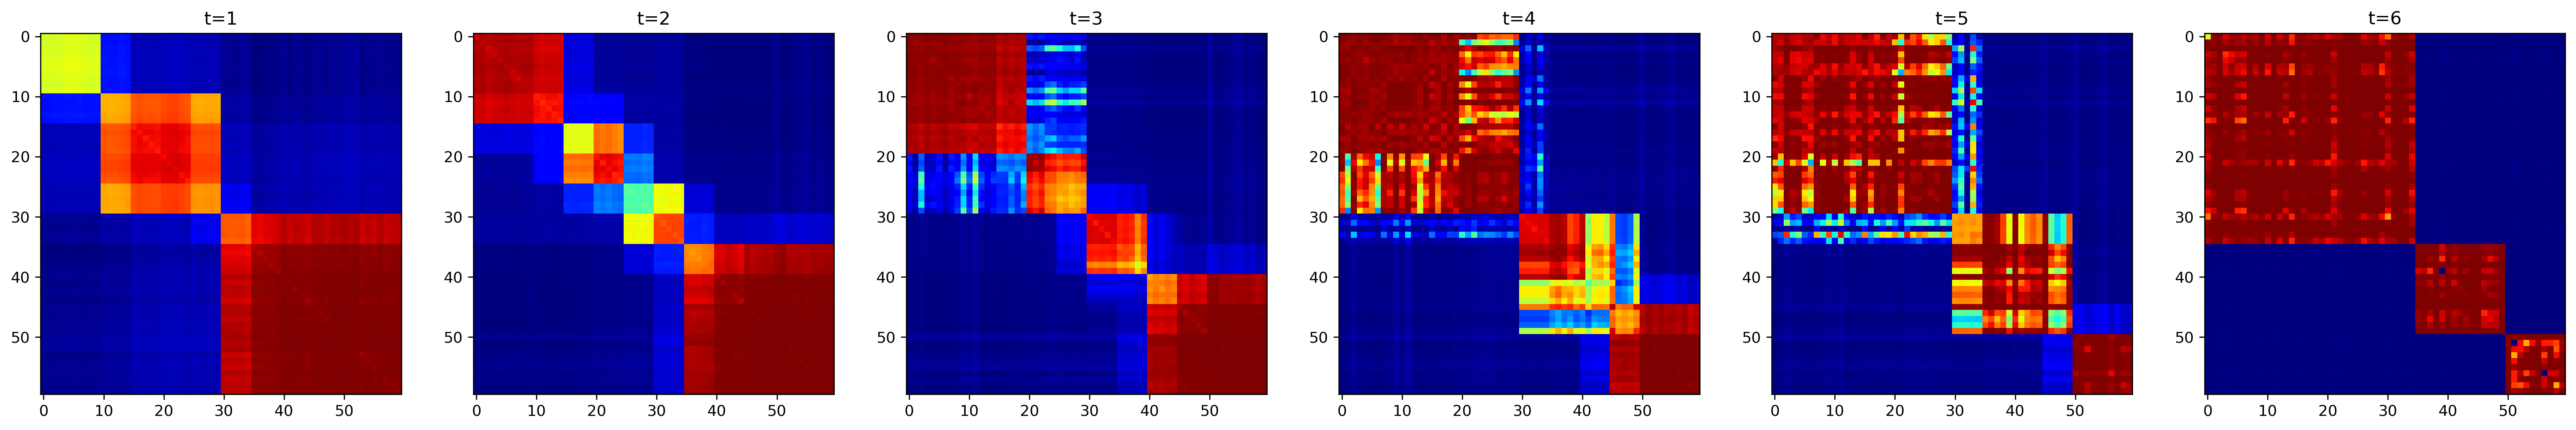

In [9]:
model = HGPDR(config)
Probsamps = torch.zeros(config.T, config.N, config.N)
ProbAve = torch.zeros_like(Probsamps)

progress_bar = tqdm(range(config.burnin + config.collection))
for i in progress_bar:
    k = model.do_inference(B, m_idx, n_idx)

    for t in range(config.T):
        Prob = model.phi[t] @ model.lam_kk @ model.phi[t].T + eps
        Prob = 1 - torch.exp(-Prob)
        if i > config.burnin:
            Probsamps[t] = Probsamps[t] + Prob
            ProbAve[t] = Probsamps[t] / (i - config.burnin)
        else:
            ProbAve[t] = Prob

    if (i+1) % 300 == 0:
        fig, ax = plt.subplots(1, config.T, figsize=(30, 5), dpi=300)
        for t in range(config.T):
            ax[t].imshow(ProbAve[t] + ProbAve[t].T, cmap='jet')
            ax[t].set_title(f't={t+1}')

    progress_bar.set_description(f'K:{k}, gamma_0:{model.gamma_0:.5f}')

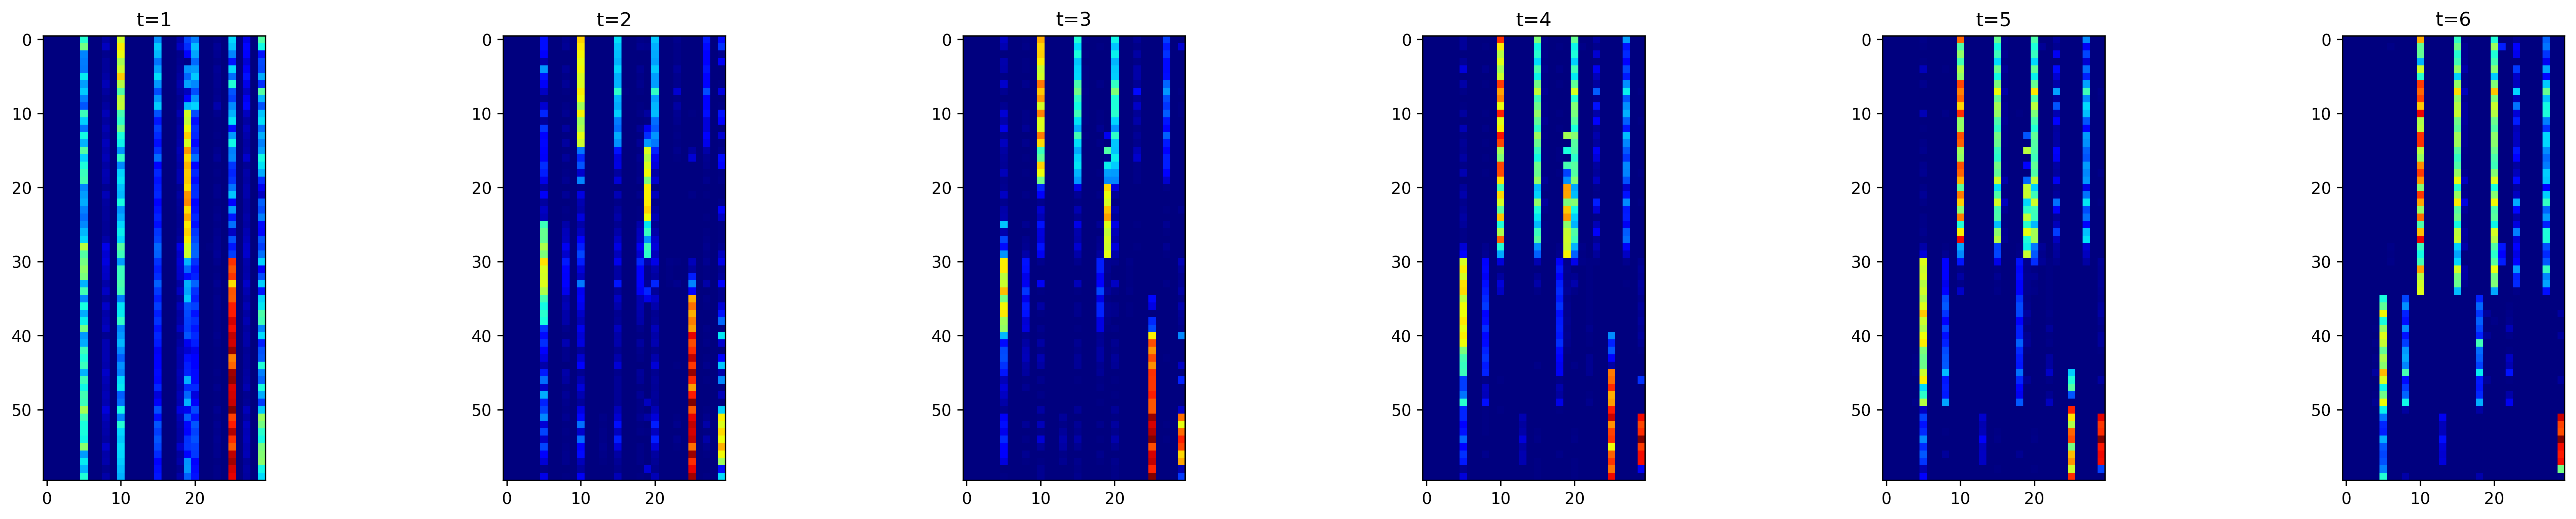

In [ ]:
fig, ax = plt.subplots(1, config.T, figsize=(30, 5), dpi=300)
for t in range(config.T):
    latent_feature = torch.log(model.phi[t] @ model.lam_kk + 0.01)
    ax[t].imshow(latent_feature, cmap='jet')
    ax[t].set_title(f't={t+1}')

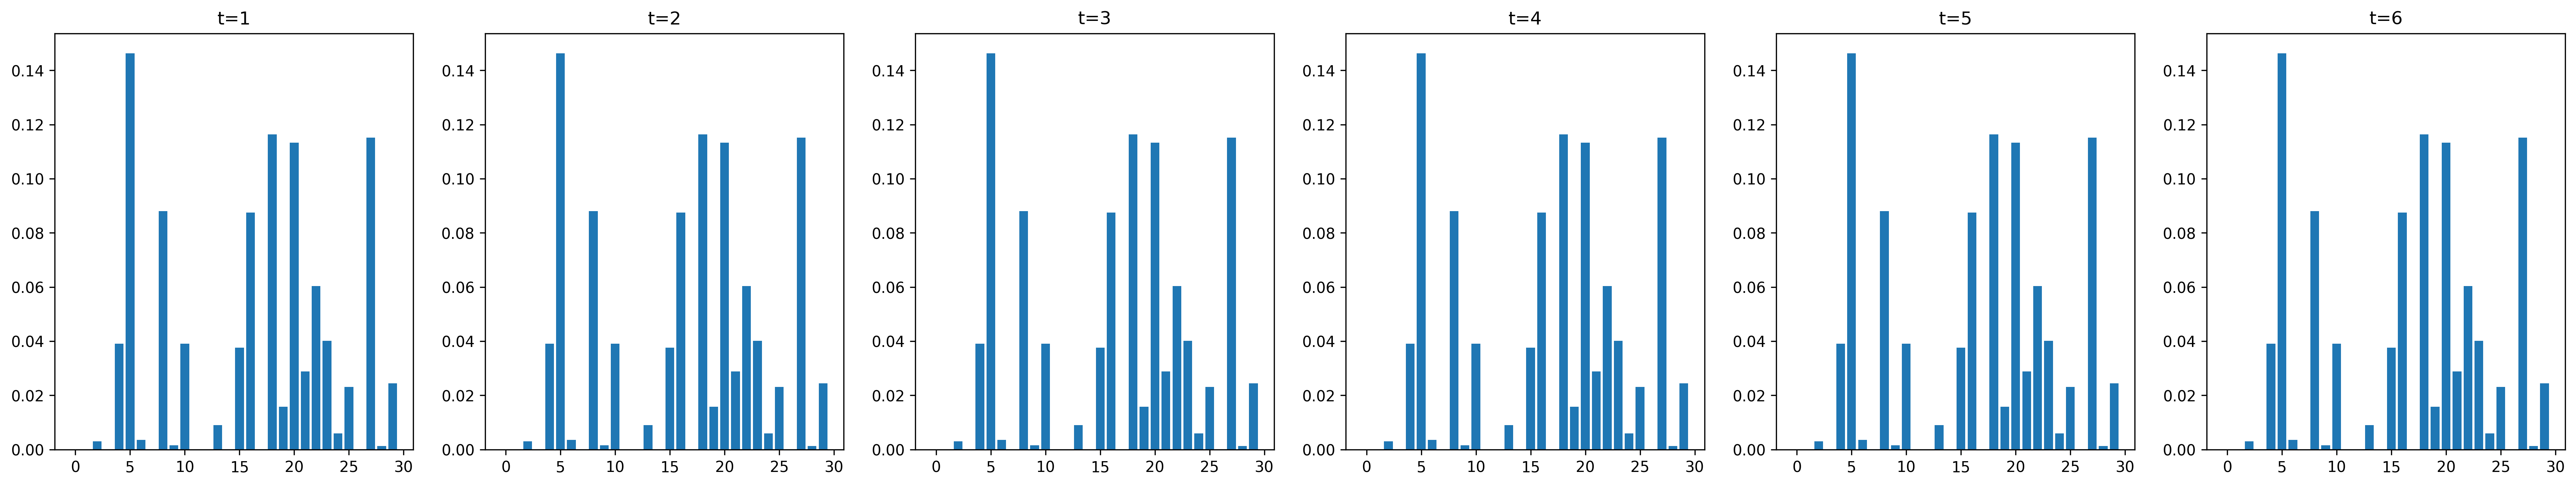

In [ ]:
fig, ax = plt.subplots(1, config.T, figsize=(30, 5), dpi=300)
for t in range(config.T):
    ax[t].bar(torch.arange(config.K), model.r / model.r.sum())
    ax[t].set_title(f't={t+1}')